In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [3]:
%load_ext qat.core.magic

The qat.core.magic extension is already loaded. To reload it, use:
  %reload_ext qat.core.magic


In [5]:
#Conexion a la QPU
from qat.qlmaas import QLMaaSConnection
connection = QLMaaSConnection(hostname="qlm")#, port=...)
LinAlg = connection.get_qpu("qat.qpus:LinAlg")
lineal_qpu = LinAlg()

Username: gferro
········


In [ ]:
from qat.qpus import PyLinalg
lineal_qpu = PyLinalg()

# Librería Integral MonteCarlo Cuántica

In [6]:
def GetResults(circuit, linalgqpu, Qass=True):
    #Create a Job from the circuit
    job = circuit.to_job()
    #Import and create the linear algebra simulator
    """
    try:
        from qat.qpus import LinAlg
        linalgqpu = LinAlg()
    except ImportError:
        from qat.qpus import PyLinalg
        linalgqpu = PyLinalg()
    """

    #Submit the job to the simulator LinAlg and get the results
    result = linalgqpu.submit(job)
    QP = []
    States = []
    QA = []
    #Print the results
    if Qass:
        result = result.join()
        
    for sample in result:
        #print("State %s probability %s amplitude %s" % (sample.state, sample.probability, sample.amplitude))
        QP.append(sample.probability)
        States.append(str(sample.state))
        QA.append(sample.amplitude)
    QP = pd.Series(QP, name='Probability')
    States = pd.Series(States, name='States')  
    QA = pd.Series(QA, name='Amplitude') 
    pdf = pd.concat([States, QP, QA], axis=1)
    return pdf, circuit    


## 1. Genera Arrays de Probabilidad

Dada una densidad de probabilidad $p(x)$ sobre un interval $[a,b]$ quiero poder discretizarla en $2^{n}$ bins con $n$ el número de qbits sobre los que quiero cargar la probabilidad. La idea es que tanto la función como la probabilidad se den en un array numpy. 

La función *get_histogram* nos permitiría generar el array numpy de una distribución de probabilidad que se le pase en forma de función python. Generaría los centros de los bins y las probabilidades de los centros.

In [7]:
from qat.lang.AQASM import QRoutine, AbstractGate, X, RY, CNOT, Program, H

In [8]:
def get_histogram(p, a, b, nbin):
    """
    Given a function p, convert it into a histogram. The function must be positive, the normalization is automatic.
    Note that instead of having an analytical expression, p could just create an arbitrary vector of the right dimensions and positive amplitudes
    so that this procedure could be used to initialize any quantum state with real amplitudes
    
    a    (float)    = lower limit of the interval
    b    (float)    = upper limit of the interval
    p    (function) = function that we want to convert to a probability mass function. It does not have to be normalized but must be positive in the interval
    nbin (int)      = number of bins in the interval
    """
    #Should be a function
    assert callable(p)
    
    nqbits_ = np.log2(nbin)
    
    assert (nqbits_%2 ==0) or (nqbits_%2 ==1),  'nbin must be 2^n with n a int. In this case is: {}.'.format(nqbits_)
    
    step = (b-a)/nbin
    #center calculation
    centers = np.array([a+step*(i+1/2) for i in range(nbin)])
    
    prob_n = p(centers)
    assert np.all(prob_n>=0.), 'Probabilities must be positive, so p must be a positive function'
    probs = prob_n/np.sum(prob_n)
    assert np.isclose(np.sum(probs), 1.), 'Probability is not getting normalized properly'
    return centers, probs

In [9]:
#Función de probabilidad de prueba
def p(x):
    return x*x
def f(x):
    return np.sin(x)

In [10]:
a=0.0
b=1.0
nqbits = 8
nbins = 2**nqbits

X, p_X = get_histogram(p, a, b, nbins)
f_X = f(X)

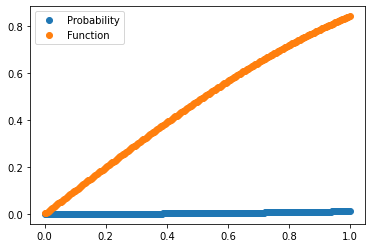

In [11]:
%matplotlib inline
plt.plot(X, p_X, 'o')
plt.plot(X, f_X, 'o')
plt.legend(['Probability', 'Function'])
plt.show()

## 2. Carga Probabilidad

Con la distribuición de probabilidad carga en forma de dos arrays (uno el de centros y otro el de las probabilidades de los centros) voy a intentar generar una función que carge dichas probabilidades en un estado cuántico. Para ello genero la función **LoadProbability_Gate** que lo que hace será descargar el proceso de carga en una puerta cuántica. 

Para poder generar dicha puerta necesito generar rotaciones sobre un qbit controladas por $m$ qbits. Para ello utilizo multiplexores cuánticos. La implementación que tengo de dichos multiplexores es una suerte de función recursiva pero me gustaría generar una puerta que pueda utilizar para generar dichas rotaciones controladas...


In [12]:
def multiplexor_RY_m_recurs(qprog, qbits, thetas, m, j, sig = 1.):
    """ 
    Auxiliary function to create the recursive part of a multiplexor that applies an RY gate
    
    qprog = Quantum Program in which we want to apply the gates
    qbits = Nmber of qubits of the quantum program
    thetas (np.ndarray) = numpy array containing the set of angles that we want to apply
    m   (int) = number of remaining controls
    j   (int) = index of the target qubits
    sig (float) = accounts for wether our multiplexor is being decomposed with its lateral CNOT at the right or at the left, even if that CNOT is not present because it cancelled out (its values can only be +1. and -1.)
    """
    assert isinstance(m, int), 'm must be an integer'
    assert isinstance(j, int), 'j must be an integer'
    assert sig == 1. or sig == -1., 'sig can only be -1. or 1.'
    if m > 1:
        # If there is more that one control, the multiplexor shall be decomposed.
        # It can be checked that the right way to decompose it taking into account the simplifications is as
        x_l = 0.5*np.array([thetas[i]+sig*thetas[i+len(thetas)//2] for i in range (len(thetas)//2)]) #left angles
        x_r = 0.5*np.array([thetas[i]-sig*thetas[i+len(thetas)//2] for i in range (len(thetas)//2)]) #right angles
        
        multiplexor_RY_m_recurs(qprog, qbits, x_l, m-1, j, 1.)
        qprog.apply(CNOT, qbits[j-m], qbits[j])
        multiplexor_RY_m_recurs(qprog, qbits, x_r, m-1, j, -1.)
        
        # Just for clarification, if we hadn't already simplify the CNOTs, the code should have been
        # if sign == -1.:
        #   multiplexor_RY_m_recurs(qprog, qbits, x_l, m-1, j, -1.)
        # qprog.apply(CNOT, qbits[j-m], qbits[j])
        # multiplexor_RY_m_recurs(qprog, qbits, x_r, m-1, j, -1.)
        # qprog.apply(CNOT, qbits[j-m], qbits[j])
        # if sign == 1.:
        #   multiplexor_RY_m_recurs(qprog, qbits, x_l, m-1, j, 1.)
        
    else: 
        # If there is only one control just apply the Ry gates
        ThetaPositive = (thetas[0]+sig*thetas[1])/2.0
        ThetaNegative = (thetas[0]-sig*thetas[1])/2.0
        qprog.apply(RY(ThetaPositive), qbits[j])
        qprog.apply(CNOT, qbits[j-1], qbits[j])
        qprog.apply(RY(ThetaNegative), qbits[j])
        
            
def multiplexor_RY_m(qprog, qbits, thetas, m, j):
    """
    Create a multiplexor that applies an RY gate on a qubit controlled by the former m qubits
    It will have its lateral cnot on the right.

    qprog = Quantum Program in which we want to apply the gates
    qbits = Nmber of qubits of the quantum program
    thetas (np.ndarray) = numpy array containing the set of angles that we want to apply
    m      (int) = number of remaining controls
    j      (int) = index of the target qubits
    """
    multiplexor_RY_m_recurs(qprog, qbits, thetas, m, j)
    qprog.apply(CNOT, qbits[j-m], qbits[j])
    
def LoadProbability_Gate(ProbabilityArray, CentersArray):
    """
    Given a discretized probability array the function creates a AbstracGate that allows the load
    of the probability in a Quantum State. The number of qbits of the gate will be log2(len(ProbabilityArray))
    Inputs:
    * ProbabilityArray: np.array. Discretized arrray with the probability to load
    Outuput:
    * P_gate: Abstract Gate. Gate for loading Input probability in a quantum state
    """
    
    
    #Number of Input qbits for the QWuantum Gate
    nqbits_ = np.log2(len(ProbabilityArray))
    #Probability array must have a dimension of 2^n.
    Condition = (nqbits_%2 ==0) or (nqbits_%2 ==1)
    assert Condition, 'Length of the ProbabilityArray must be of dimension 2^n with n a int. In this case is: {}.'.format(nqbits_)
    
    nqbits = int(nqbits_)
    nbins = len(ProbabilityArray)
    
    P = AbstractGate("P", [int])
    def P_generator(nqbits):
        rout = QRoutine()
        reg = rout.new_wires(nqbits)
        print(reg)
        # Now go iteratively trough each qubit computing the probabilities and adding the corresponding multiplexor
        for m in range(nqbits):
            n_parts = 2**(m+1) #Compute the number of subzones which the current state is codifying
            edges = np.array([a+(b-a)*(i)/n_parts for i in range(n_parts+1)]) #Compute the edges of that subzones
        
            # Compute the probabilities of each subzone by suming the probabilities of the original histogram.
            # There is no need to compute integrals since the limiting accuracy is given by the original discretization.
            # Moreover, this approach allows to handle non analytical probability distributions, measured directly from experiments
            p_zones = np.array([np.sum(ProbabilityArray[np.logical_and(CentersArray>edges[i],CentersArray<edges[i+1])]) for i in range(n_parts)])
            # Compute the probability of standing on the left part of each zone 
            p_left = p_zones[[2*j for j in range(n_parts//2)]]
            # Compute the probability of standing on each zone (left zone + right zone)
            p_tot = p_left + p_zones[[2*j+1 for j in range(n_parts//2)]]
            
            # Compute the rotation angles
            thetas = 2.0*np.arccos(np.sqrt(p_left/p_tot))

            if m == 0:
                # In the first iteration it is only needed a RY gate
                rout.apply(RY(thetas[0]), reg[0])
            else:
                # In the following iterations we have to apply multiplexors controlled by m qubits
                # We call a function to construct the multiplexor, whose action is a block diagonal matrix of Ry gates with angles theta
                multiplexor_RY_m(rout, reg, thetas, m, m)
        return rout
    P.set_circuit_generator(P_generator)
    P_gate = P(nqbits)
    return P_gate



In [13]:
from qat.lang.AQASM import Program
qprog = Program()
qbits = qprog.qalloc(nqbits)
P_gate = LoadProbability_Gate(p_X, X)
qprog.apply(P_gate, qbits)

[<qat.lang.AQASM.bits.Qbit object at 0x14ecc519bd60>, <qat.lang.AQASM.bits.Qbit object at 0x14ecbfc7e370>, <qat.lang.AQASM.bits.Qbit object at 0x14ecbfbcc2b0>, <qat.lang.AQASM.bits.Qbit object at 0x14ecbfbcc940>, <qat.lang.AQASM.bits.Qbit object at 0x14ecbfbccd60>, <qat.lang.AQASM.bits.Qbit object at 0x14ecbfbccb50>, <qat.lang.AQASM.bits.Qbit object at 0x14ecbfbccee0>, <qat.lang.AQASM.bits.Qbit object at 0x14ecbfbccc70>]


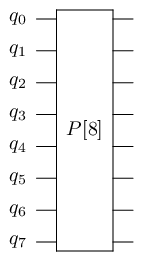

In [14]:
circuit = qprog.to_circ()
%qatdisplay circuit --depth 0

In [15]:
Pm, _ = GetResults(circuit, lineal_qpu, True)

Submitted a new batch: Job236


In [16]:
np.isclose(Pm['Probability'], p_X).all()

True

In [ ]:
Path2 = '/home/gferro/Code/PhaseAmplification/'
#Path2 = '/home/cesga/gferro/QLM_Backup/Code/PhaseAmplification/'
if os.path.exists(Path2):
    sys.path.append(Path2)
else: 
    raise FileNotFoundError('File does not exist')
from dataloading_module import LeftConditionalProbability
from dataloading_module import CreatePG

In [ ]:
from qat.lang.AQASM import Program
qprogZ = Program()
qbitsZ= qprogZ.qalloc(nqbits)
Z_P_gate = LoadProbability_Gate(p_X, X)
qprogZ.apply(Z_P_gate, qbitsZ)

In [ ]:
circuitZ = qprogZ.to_circ()
%qatdisplay circuitZ --depth 0

In [ ]:
PmZ, _ = GetResults(circuitZ, lineal_qpu, True)

In [ ]:
np.isclose(PmZ['Probability'], p_X).all()

In [ ]:
np.isclose(Pm['Probability'], PmZ['Probability']).all()

In [ ]:
def load_function(centers, f, nqbits):
    """
    Load the values of the function f on the states in which the value of the auxiliary qubit is 1 once the probabilities are already loaded.
    
    PARAMETERS:
    centers (np.ndarray) : center of each considered bin
    f       (function)   : function that we want to load. Its image must be contained in [0, 1]
    nqbits  (int)        : number of qubits used WITHOUT counting the auxiliary qubit
    
    RETURNS:
    R_gate (ParamGate) : gate that loads the function into the amplitudes
    y      (np.ndarray)  : array containing the value of the function in each bin
    """
    y = f(centers)
    assert np.all(y<=1.), 'The image of the function must be less than 1. Rescaling is required'
    assert np.all(y>=0.), 'The image of the function must be greater than 0. Rescaling is required'
    assert isinstance(y, np.ndarray), 'the output of the function p must be a numpy array'
    thetas = np.arcsin(np.sqrt(y))

    R = AbstractGate("R", [int] + [float for theta in thetas])
    def R_generator(nqbits, *thetas):
        rout = QRoutine()
        reg = rout.new_wires(nqbits+1)
        multiplexor_RY_m(rout, reg, thetas, nqbits, nqbits)
        return rout
    R.set_circuit_generator(R_generator)
    R_gate = R(nqbits, *thetas)
    return R_gate, y


############################# REVISAR A PARTIR DE AQUI

In [ ]:
#Configuración del algoritmo
nqbits = 5
nbins = 2**nqbits
a = 0
b = 1
#Creamos la probabilidad discretizada que queremos cargar
centers, probs = get_histogram(p, a, b, nbins)
qprog = Program()
qbits = qprog.qalloc(nqbits)
LThetas = []
for i in range(0, nqbits):
    ConditionalProbability = LeftConditionalProbability(i, probs)
    Thetas = np.arccos(np.sqrt(ConditionalProbability))
    LThetas.append(Thetas)

In [ ]:
LThetas

In [ ]:
def CRBS(nqbits,thetas, m, j):
    def generator(nqbits):
        rout = QRoutine()
        reg = rout.new_wires(nqbits)
        multiplexor_RY_m_recurs(rout, reg, thetas, m, j)
        rout.apply(CNOT, reg[j-m], reg[j])
        return rout
    
    cR = AbstractGate("cR", [int])
    cR.set_circuit_generator(generator)
    return cR(nqbits)

In [ ]:
A = CRBS(3, LThetas[2], 2 ,2)

In [ ]:
A

In [ ]:
LThetas[1]

In [ ]:
#Create the circuit from the program
circuit = qprog.to_circ()

#Display the circuit
#%qatdisplay circuit
%qatdisplay circuit --depth 1

In [ ]:
qprog = Program()
qbits = qprog.qalloc(nqbits)
A = CRBS(5, LThetas[4], 4 ,4)
qprog.apply(A, qbits)

### 2.1 Rotaciones controladas por un estado

In [ ]:
Path2 = '/home/gferro/Code/PhaseAmplification/'
#Path2 = '/home/cesga/gferro/QLM_Backup/Code/PhaseAmplification/'
if os.path.exists(Path2):
    sys.path.append(Path2)
else: 
    raise FileNotFoundError('File does not exist')
    
from dataloading_module import LeftConditionalProbability

El siguiente código genera dado un array de probabilidades las diferentes $\theta$ que necesitamos cargar las probabilidades en un estado cuántico

#### Genera $\theta$

In [ ]:
#Configuración del algoritmo
LThetas = []
LCond = []
for i in range(0, nqbits):
    ConditionalProbability = LeftConditionalProbability(i, p_X)
    LCond.append(ConditionalProbability)
    Thetas = 2.0*np.arccos(np.sqrt(ConditionalProbability))
    LThetas.append(Thetas)

In [ ]:
LThetas

#### Rotaciones Controladas con Multiplexores

In [ ]:
def multiplexor_RY_m_recurs(qprog, qbits, thetas, m, j, sig = 1.):
    """ 
    Auxiliary function to create the recursive part of a multiplexor that applies an RY gate
    
    qprog = Quantum Program in which we want to apply the gates
    qbits = Nmber of qubits of the quantum program
    thetas (np.ndarray) = numpy array containing the set of angles that we want to apply
    m   (int) = number of remaining controls
    j   (int) = index of the target qubits
    sig (float) = accounts for wether our multiplexor is being decomposed with its lateral CNOT at the right or at the left, even if that CNOT is not present because it cancelled out (its values can only be +1. and -1.)
    """
    assert isinstance(m, int), 'm must be an integer'
    assert isinstance(j, int), 'j must be an integer'
    assert sig == 1. or sig == -1., 'sig can only be -1. or 1.'
    if m > 1:
        # If there is more that one control, the multiplexor shall be decomposed.
        # It can be checked that the right way to decompose it taking into account the simplifications is as
        x_l = 0.5*np.array([thetas[i]+sig*thetas[i+len(thetas)//2] for i in range (len(thetas)//2)]) #left angles
        x_r = 0.5*np.array([thetas[i]-sig*thetas[i+len(thetas)//2] for i in range (len(thetas)//2)]) #right angles
        
        multiplexor_RY_m_recurs(qprog, qbits, x_l, m-1, j, 1.)
        qprog.apply(CNOT, qbits[j-m], qbits[j])
        multiplexor_RY_m_recurs(qprog, qbits, x_r, m-1, j, -1.)
        
        # Just for clarification, if we hadn't already simplify the CNOTs, the code should have been
        # if sign == -1.:
        #   multiplexor_RY_m_recurs(qprog, qbits, x_l, m-1, j, -1.)
        # qprog.apply(CNOT, qbits[j-m], qbits[j])
        # multiplexor_RY_m_recurs(qprog, qbits, x_r, m-1, j, -1.)
        # qprog.apply(CNOT, qbits[j-m], qbits[j])
        # if sign == 1.:
        #   multiplexor_RY_m_recurs(qprog, qbits, x_l, m-1, j, 1.)
        
    else: 
        # If there is only one control just apply the Ry gates
        ThetaPositive = (thetas[0]+sig*thetas[1])/2.0
        ThetaNegative = (thetas[0]-sig*thetas[1])/2.0
        qprog.apply(RY(ThetaPositive), qbits[j])
        qprog.apply(CNOT, qbits[j-1], qbits[j])
        qprog.apply(RY(ThetaNegative), qbits[j])
        
            
def multiplexor_RY_m(qprog, qbits, thetas, m, j):
    """
    Create a multiplexor that applies an RY gate on a qubit controlled by the former m qubits
    It will have its lateral cnot on the right.

    qprog = Quantum Program in which we want to apply the gates
    qbits = Nmber of qubits of the quantum program
    thetas (np.ndarray) = numpy array containing the set of angles that we want to apply
    m      (int) = number of remaining controls
    j      (int) = index of the target qubits
    """
    multiplexor_RY_m_recurs(qprog, qbits, thetas, m, j)
    qprog.apply(CNOT, qbits[j-m], qbits[j])

def StateControlledRY(thetas):
    cSRY = AbstractGate("cSRY", [float for theta in thetas])
    def CRBS_(*thetas):
        rout = QRoutine()
        nqbits_ = int(np.log2(len(thetas)))
        #The number of controlled qbits is given by the Theta dimension
        #We need to appy the rotation on an additional qbit
        reg = rout.new_wires(nqbits_+1)
        multiplexor_RY_m(rout, reg, thetas, nqbits_, nqbits_)
        return rout
    cSRY.set_circuit_generator(CRBS_)
    return cSRY(*thetas)
    

In [ ]:
j=1
qprog = Program()
print(LThetas[j])
nqbits = int(np.log2(len(LThetas[j])))+1
print(nqbits)
qbits = qprog.qalloc(nqbits)
csRY = StateControlledRY(LThetas[j])
qprog.apply(csRY, qbits)

In [ ]:
circuit = qprog.to_circ()
%qatdisplay circuit --depth 1

In [ ]:
P, _ = GetResults(circuit, lineal_qpu, False)

In [ ]:
LThetas[j]

In [ ]:
qprog = Program()
qbits = qprog.qalloc(nqbits)
j=3
csRY = StateControlledRY(LThetas[j])

qprog.apply(csRY, qbits[:j+1])

In [ ]:
circuit = qprog.to_circ()
%qatdisplay circuit --depth 1

#### Rotaciones Controladas Raw

In [ ]:
from dataloading_module import CRBS_gate, ZStateControlledRY

In [ ]:
qprogZ = Program()
qbitsZ = qprogZ.qalloc(nqbits)
controlledR_gate = ZStateControlledRY(LThetas[j])
qprogZ.apply(controlledR_gate, qbitsZ)

In [ ]:
circuitZ = qprogZ.to_circ()
%qatdisplay circuitZ --depth 2

In [ ]:
PZ, _ = GetResults(circuitZ, lineal_qpu, False)

In [ ]:
np.isclose(PZ['Probability'], P['Probability']).all()

In [ ]:
#Rotacion controlada de varios thetas 
def ZStateControlledRY(thetas):
    ZcSRY = AbstractGate("ZcSRY", [float for theta in thetas])
    def ScRs_(*thetas):
        from qat.lang.AQASM import QRoutine
        qrout = QRoutine()
        #Numero de qbits para controlar las Thetas
        NumberOfQbits = int(np.log2(len(thetas)))
        #Controlling qbits
        qcontrol = qrout.new_wires(NumberOfQbits)
        #Additional qbit where Rotation should be applied
        qtarget = qrout.new_wires(1)
        for j, theta in enumerate(thetas):
            qrout.apply(CRBS_gate(NumberOfQbits, j, theta), qcontrol+qtarget)
        return qrout
    ZcSRY.set_circuit_generator(ScRs_)
    return ZcSRY(*thetas)

In [ ]:
qprogZ = Program()
qbitsZ = qprogZ.qalloc(nqbits)
controlledR_gate = ZStateControlledRY(LThetas[j])
qprogZ.apply(controlledR_gate, qbitsZ)

In [ ]:
circuitZ = qprogZ.to_circ()
%qatdisplay circuitZ --depth 2

In [ ]:
PZ, _ = GetResults(circuitZ, lineal_qpu, False)

In [ ]:
np.isclose(PZ['Probability'], P['Probability']).all()

## 2.2 Carga de Probabilidad

Ahora procedemos a utilizar la puerta generada para crear la carga de probabilidad

In [ ]:
def multiplexor_RY_m_recurs(qprog, qbits, thetas, m, j, sig = 1.):
    """ 
    Auxiliary function to create the recursive part of a multiplexor that applies an RY gate
    
    qprog = Quantum Program in which we want to apply the gates
    qbits = Nmber of qubits of the quantum program
    thetas (np.ndarray) = numpy array containing the set of angles that we want to apply
    m   (int) = number of remaining controls
    j   (int) = index of the target qubits
    sig (float) = accounts for wether our multiplexor is being decomposed with its lateral CNOT at the right or at the left, even if that CNOT is not present because it cancelled out (its values can only be +1. and -1.)
    """
    assert isinstance(m, int), 'm must be an integer'
    assert isinstance(j, int), 'j must be an integer'
    assert sig == 1. or sig == -1., 'sig can only be -1. or 1.'
    if m > 1:
        # If there is more that one control, the multiplexor shall be decomposed.
        # It can be checked that the right way to decompose it taking into account the simplifications is as
        x_l = 0.5*np.array([thetas[i]+sig*thetas[i+len(thetas)//2] for i in range (len(thetas)//2)]) #left angles
        x_r = 0.5*np.array([thetas[i]-sig*thetas[i+len(thetas)//2] for i in range (len(thetas)//2)]) #right angles
        
        multiplexor_RY_m_recurs(qprog, qbits, x_l, m-1, j, 1.)
        qprog.apply(CNOT, qbits[j-m], qbits[j])
        multiplexor_RY_m_recurs(qprog, qbits, x_r, m-1, j, -1.)
        
        # Just for clarification, if we hadn't already simplify the CNOTs, the code should have been
        # if sign == -1.:
        #   multiplexor_RY_m_recurs(qprog, qbits, x_l, m-1, j, -1.)
        # qprog.apply(CNOT, qbits[j-m], qbits[j])
        # multiplexor_RY_m_recurs(qprog, qbits, x_r, m-1, j, -1.)
        # qprog.apply(CNOT, qbits[j-m], qbits[j])
        # if sign == 1.:
        #   multiplexor_RY_m_recurs(qprog, qbits, x_l, m-1, j, 1.)
        
    else: 
        # If there is only one control just apply the Ry gates
        ThetaPositive = (thetas[0]+sig*thetas[1])/2.0
        ThetaNegative = (thetas[0]-sig*thetas[1])/2.0
        qprog.apply(RY(ThetaPositive), qbits[j])
        qprog.apply(CNOT, qbits[j-1], qbits[j])
        qprog.apply(RY(ThetaNegative), qbits[j])
        
            
def multiplexor_RY_m(qprog, qbits, thetas, m, j):
    """
    Create a multiplexor that applies an RY gate on a qubit controlled by the former m qubits
    It will have its lateral cnot on the right.

    qprog = Quantum Program in which we want to apply the gates
    qbits = Nmber of qubits of the quantum program
    thetas (np.ndarray) = numpy array containing the set of angles that we want to apply
    m      (int) = number of remaining controls
    j      (int) = index of the target qubits
    """
    multiplexor_RY_m_recurs(qprog, qbits, thetas, m, j)
    qprog.apply(CNOT, qbits[j-m], qbits[j])

def StateControlledRY(thetas):
    cSRY = AbstractGate("cSRY", [float for theta in thetas])
    def CRBS_(*thetas):
        rout = QRoutine()
        nqbits_ = int(np.log2(len(thetas)))
        #The number of controlled qbits is given by the Theta dimension
        #We need to appy the rotation on an additional qbit
        reg = rout.new_wires(nqbits_+1)
        multiplexor_RY_m(rout, reg, thetas, nqbits_, nqbits_)
        return rout
    cSRY.set_circuit_generator(CRBS_)
    return cSRY(*thetas)
    

In [ ]:
CentersArray = X
ProbabilityArray = p_X

rout = Program()
reg = rout.qalloc(nqbits)
LThetas = []
gates = []
for m in range(4):
    n_parts = 2**(m+1) #Compute the number of subzones which the current state is codifying
    edges = np.array([a+(b-a)*(i)/n_parts for i in range(n_parts+1)]) #Compute the edges of that subzones
    p_zones = np.array([np.sum(ProbabilityArray[np.logical_and(CentersArray>edges[i],CentersArray<edges[i+1])]) for i in range(n_parts)])
    p_left = p_zones[[2*j for j in range(n_parts//2)]]
    p_tot = p_left + p_zones[[2*j+1 for j in range(n_parts//2)]]
    thetas = 2.0*np.arccos(np.sqrt(p_left/p_tot))
    LThetas.append(thetas)
    if m == 0:
        # In the first iteration it is only needed a RY gate
        rout.apply(RY(thetas[0]), reg[0])    
        gates.append(None)
    else:
        #multiplexor_RY_m(rout, reg, thetas, m, m)
        csRY = StateControlledRY(thetas)
        #rout.apply(csRY, reg[:m+2])
        gates.append(csRY)
    

In [ ]:
len(reg)

In [ ]:
rout.apply(gates[1], reg[:2])

In [ ]:
rout = Program()
m=3
reg = rout.qalloc(nqbits)
rout.apply(gates[m], reg[:m+2]) 

In [ ]:
circuit = rout.to_circ()
%qatdisplay circuit --depth 2

In [ ]:
rout.

In [ ]:
        print('Len Thetas: {}'.format(len(thetas)))
        csRY = StateControlledRY(thetas)
        qbits4thetas = int(np.log2(len(thetas)))+1
        print('qbits4thetas: {}'.format(qbits4thetas))
        print(reg[:qbits4thetas])
        rout.apply(csRY, reg[:qbits4thetas])

In [ ]:
def LoadProbability_Gate(ProbabilityArray, CentersArray):
    """
    Given a discretized probability array the function creates a AbstracGate that allows the load
    of the probability in a Quantum State. The number of qbits of the gate will be log2(len(ProbabilityArray))
    Inputs:
    * ProbabilityArray: np.array. Discretized arrray with the probability to load
    Outuput:
    * P_gate: Abstract Gate. Gate for loading Input probability in a quantum state
    """
    
    
    #Number of Input qbits for the QWuantum Gate
    nqbits_ = np.log2(len(ProbabilityArray))
    #Probability array must have a dimension of 2^n.
    Condition = (nqbits_%2 ==0) or (nqbits_%2 ==1)
    assert Condition, 'Length of the ProbabilityArray must be of dimension 2^n with n a int. In this case is: {}.'.format(nqbits_)
    
    nqbits = int(nqbits_)
    nbins = len(ProbabilityArray)
    
    P = AbstractGate("P", [int])
    def P_generator(nqbits):
        rout = QRoutine()
        reg = rout.new_wires(nqbits)
        print(reg)
        # Now go iteratively trough each qubit computing the probabilities and adding the corresponding multiplexor
        for m in range(nqbits):
            n_parts = 2**(m+1) #Compute the number of subzones which the current state is codifying
            edges = np.array([a+(b-a)*(i)/n_parts for i in range(n_parts+1)]) #Compute the edges of that subzones
        
            # Compute the probabilities of each subzone by suming the probabilities of the original histogram.
            # There is no need to compute integrals since the limiting accuracy is given by the original discretization.
            # Moreover, this approach allows to handle non analytical probability distributions, measured directly from experiments
            p_zones = np.array([np.sum(ProbabilityArray[np.logical_and(CentersArray>edges[i],CentersArray<edges[i+1])]) for i in range(n_parts)])
            # Compute the probability of standing on the left part of each zone 
            p_left = p_zones[[2*j for j in range(n_parts//2)]]
            # Compute the probability of standing on each zone (left zone + right zone)
            p_tot = p_left + p_zones[[2*j+1 for j in range(n_parts//2)]]
            
            # Compute the rotation angles
            thetas = 2.0*np.arccos(np.sqrt(p_left/p_tot))

            if m == 0:
                # In the first iteration it is only needed a RY gate
                rout.apply(RY(thetas[0]), reg[0])
            else:
                # In the following iterations we have to apply multiplexors controlled by m qubits
                # We call a function to construct the multiplexor, whose action is a block diagonal matrix of Ry gates with angles theta
                csRY = StateControlledRY(thetas)
                qbits4thetas = int(np.log2(len(thetas)))
                print('qbits4thetas: {}'.format(qbits4thetas))
                print('len reg: {}'.format(len(reg)))
                #multiplexor_RY_m(rout, reg, thetas, m, m)
                rout.apply(csRY, reg[:qbits4thetas])
        return rout
    P.set_circuit_generator(P_generator)
    P_gate = P(nqbits)
    return P_gate


In [ ]:
circuit = rout.to_circ()
%qatdisplay circuit --depth 2

In [ ]:
a=0.0
b=1.0
nqbits = 5
nbins = 2**nqbits

X, p_X = get_histogram(p, a, b, nbins)
f_X = f(X)

In [ ]:
p_X

In [ ]:
P, _ = GetResults(circuit, lineal_qpu, False)

In [ ]:
np.isclose(P['Probability'], p_X).all()

In [ ]:
from dataloading_module import CreatePG

In [ ]:
from qat.lang.AQASM import Program
qprogZ = Program()
qbitsZ = qprogZ.qalloc(nqbits)
Z_P_gate = CreatePG(p_X)
qprogZ.apply(Z_P_gate, qbitsZ)

In [ ]:
circuitZ = qprogZ.to_circ()
%qatdisplay circuitZ --depth 3

In [ ]:
PZ, _ = GetResults(circuitZ, lineal_qpu, False)

In [ ]:
np.isclose(PZ['Probability'], p_X).all()

In [ ]:
np.isclose(PZ['Probability'], P['Probability']).all()